<h1 align="center"> Metody Obliczeniowe w Nauce i Technicie </h1>
<h2 align="center"> Laboratorium 5 </h2>
<h2 align="center"> Symulowane wyżarzanie </h2>
<h3 align="center"> Problem obrazka binarnego </h3>
<h3 align="center"> Mateusz Praski </h3>

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from random import randrange
from anneal import SimulatedAnnealing as Anneal
from math import log, exp
from numba import jit

Generator początkowych obrazków

In [2]:
def spawn_random_image(n, delta):
    output = np.zeros((n, n), dtype='int8')
    output[np.random.rand(n, n) <= delta] = 1
    return output

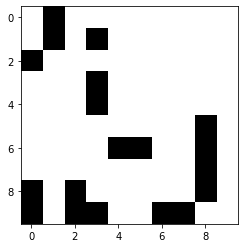

In [3]:
image = spawn_random_image(10, 0.2)
plt.imshow(image, cmap='Greys')

# Generowanie stanów sąsiednich

Pierwszym pomysłem generowania stanów sąsiednich było wybranie losowego podzbioru punktów na mapie (domyślnie 10% obrazka) a następnie dokonania permutacji na danym podzbiorze. Jednakże metoda okazała się nieefektywna dla obrazków gdzie częstotliwość jednego z kolorów była większa od drugiego. W takich przypadkach często dochodziło do sytuacji gdy po zamianie pikseli obrazek pozostawał ten sam. 

In [4]:
@jit
def yield_permutate_nhbd(image, inplace=False, size=0.1):
    new_img = image if inplace else image.copy()
    old_shape = new_img.shape
    new_img = new_img.ravel()
    random_mask = np.random.rand(*new_img.shape) <= size
    new_img[random_mask] = np.random.permutation(new_img[random_mask])
    return new_img.reshape(old_shape)

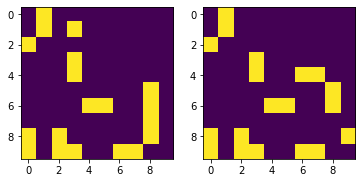

In [5]:
nhbd = yield_permutate_nhbd(image)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[1].imshow(nhbd)

Rozwiązaniem tego pomysłu była alternatywna metoda generowania sąsiedztwa. W tym przypadku losowo zostaje wybrane $K$ czarnych oraz białych pikseli, dzięki czemu mamy pewność, że obrazek nie będzie identyczny po przejściu

In [6]:
@jit
def yield_swap_nhbd(image, inplace=False, swap_size=30):
    image = image if inplace else image.copy()
    n = image.shape[0]
    image = image.ravel()
    zeros = np.where(image == 0)
    ones = np.where(image == 1)
    swap_size = min(len(zeros[0]), len(ones[0]), swap_size)
    a = np.random.choice(zeros[0], swap_size, replace=False)
    b = np.random.choice(ones[0], swap_size, replace=False)
    image[a] = 1
    image[b] = 0
    
    return image.reshape(n, n)

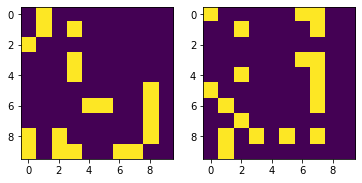

In [7]:
nhbd = yield_swap_nhbd(image)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[1].imshow(nhbd)

In [8]:
i = spawn_random_image(100, 0.3)

In [9]:
%%timeit
yield_swap_nhbd(i)

180 µs ± 3.39 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
%%timeit
yield_permutate_nhbd(i)

112 µs ± 2.47 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Podstawowe typy sąsiedztwa

4-sąsiedztwo

In [11]:
@jit
def get_4_nhbd(shape, x, y):
    mask = np.zeros(shape, dtype='bool')
    n = shape[0]
    mask[max(x-1, 0):min(x+2, n), y] = True
    mask[x, max(y-1, 0):min(y+2, n)] = True
    mask[x, y] = False
    return mask

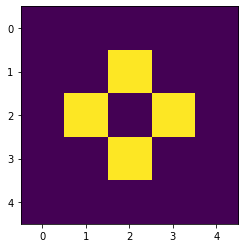

In [12]:
plt.imshow(get_4_nhbd((5, 5), 2, 2))

8-sąsiedztwo

In [13]:
@jit
def get_8_nhbd(shape, x, y):
    mask = np.zeros(shape, dtype='bool')
    n = shape[0]
    mask[max(x-1, 0):min(x+2, n), max(y-1, 0):min(y+2, n)] = True
    mask[x, y] = False
    return mask

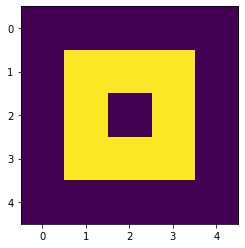

In [14]:
plt.imshow(get_8_nhbd((5, 5), 2, 2))

16-sąsiedztwo

In [15]:
@jit
def get_16_nhbd(shape, x, y):
    mask = np.zeros(shape, dtype='bool')
    n = shape[0]
    if x > 0:
        mask[x-1, max(y-2, 0) : min(y+3, n)] = True
    if x < n-1:
        mask[x+1, max(y-2, 0) : min(y+3, n)] = True
    if y > 0:
        mask[max(x-2, 0) : min(x+3, n), y-1] = True
    if y < n-1:
        mask[max(x-2, 0) : min(x+3, n), y+1] = True
            
    mask[x, y] = False
    return mask
get_16_nhbd.size = 16

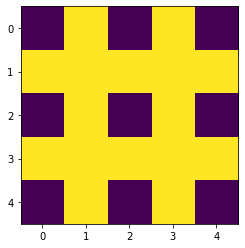

In [16]:
plt.imshow(get_16_nhbd((5, 5), 2, 2))

Sąsiedztwo w postaci obwodu kwadratu

In [17]:
@jit
def get_square_nhbd(shape, x, y, dist):
    mask = np.zeros(shape, dtype='bool')
    n = shape[0]
    mask[max(x-dist, 0):min(x+dist+1, n), max(y-dist, 0):min(y+dist+1, n)] = True
    mask[max(x-dist+1, 0):min(x+dist, n), max(y-dist+1, 0):min(y+dist, n)] = False
    return mask

In [18]:
def yield_square_nhbd(dist):
    return lambda x, y, z: get_square_nhbd(x, y, z, dist)

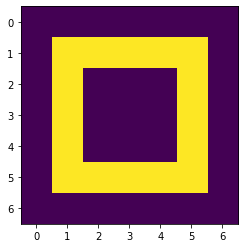

In [19]:
plt.imshow(get_square_nhbd((7, 7), 3, 3, 2))

`Black penalty` - dla każdego czarnego piksela wylicza karę równą liczbe czarnych pikseli w zadanej masce

In [ ]:
# Scores for black colors in nhbd of black cells
# @jit
def black_penalty(image, mask):
    penalty = 0
    n = image.shape[0]
    for y in range(n):
        for x in range(n):
            if image[y, x]:
                m = mask(image.shape, y, x)
                penalty += np.sum(image[m])
    return penalty

`White penalty` - dla każdego czarnego piksela wylicza karę równą liczbie białych pikseli w zadanej masce

In [ ]:
# @jit
def white_penalty(image, mask):
    penalty = 0
    n = image.shape[0]
    for y in range(n):
        for x in range(n):
            if image[y, x]:
                m = mask(image.shape, y, x)
                penalty += np.sum(m) - np.sum(image[m])
    return penalty

Funkcja składająca zbiór masek wraz ze współczynnikami w jedną funkcję kosztu.

In [22]:
def penalty_map(image, masks, coef):
    return np.sum([
        c * white_penalty(image, mask)
        for c, mask in zip(coef, masks)
    ])

# Implementacja symulowanego wyżarzania dla obrazków

Zachodzi tu drobna zmiana pomiędzy poprzednimi funkcjami. W przypadku funkcji kosztu, jeśli współczynnik jest ujemny, to przyjmowane jest `black penalty` zamiast `white penalty` a współczynnik zostaje zamieniony na wartość absolutną

In [20]:
class ImageAnneal(Anneal):
    def __init__(self, n, delta, masks, coeff, swaps):
        super().__init__()
        self.n = n
        self.delta = delta
        self.masks = masks
        self.coef = coeff
        self.swaps = swaps
        
    def init(self):
        output = np.zeros((self.n, self.n), dtype='int8')
        output[np.random.rand(self.n, self.n) <= self.delta] = 1
        return output
    
    def cost(self, image):
        return np.sum([
            c * white_penalty(image, mask) if c > 0 else -c * black_penalty(image, mask)
            for c, mask in zip(self.coef, self.masks)
        ])
    
    def get_neighbour(self, image):
        image = image.copy()
        n = image.shape[0]
        image = image.ravel()
        zeros = np.where(image == 0)
        ones = np.where(image == 1)
        swap_size = min(len(zeros[0]), len(ones[0]), self.swaps)
        a = np.random.choice(zeros[0], swap_size, replace=False)
        b = np.random.choice(ones[0], swap_size, replace=False)
        image[a] = 1
        image[b] = 0
        return image.reshape(n, n)

Funkcja tworząca maskę w postaci różnić dwóch zadanych masek

In [ ]:
def nhbd_diff(n1, n2):
    return lambda *x: n1(*x) & ~n2(*x)

In [ ]:
def show_solution(model, sol, w=8, h=4):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(sol, cmap='Greys')
    ax[0].set_title('Otrzymany obrazek')
    story = model.story
    x = list(range(len(story)))
    y = [u[1] for u in story]
    ax[1].plot(x, y)
    ax[1].set_title('Entropia w czasie')
    fig.set_size_inches(w, h)

# Symulowane wyżarzanie na podstawowych maskach

- 4-sąsiedztwo, koszt jest naliczany za czarne piksele w otoczeniu czarnych
- obrazek 64x64 gęstość 0.1
- liczba zamian w sąsiedztwie rozwiązań 10

In [160]:
model = ImageAnneal(
    64, 0.1,
    [get_4_nhbd],
    [-1],
    10
)

- Początkowa temperatura 30
- Funkcja temperatury wykładnicza o współczynniku $\alpha=0.997$
- Maksymalna liczba epok bez poprawy 500

Current temperature: 0.015128166938299142 	 Current solution: 10 	 Best solution: 10 		Number of epochs without improvement reached max_stagnation

Number of epochs: 2528


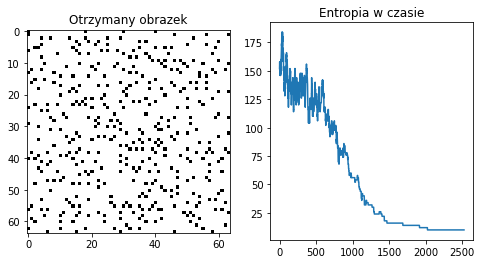

In [76]:
sol, score = model.fit(
    initial_temp = 30,
    alpha = 0.997,
    max_stagnation = 500,
    epsilon = 1e-5,
    break_point=0
)
show_solution(model, sol)

- Początkowa temperatura 3
- Funkcja temperatury liniowa o współczynniku $\alpha=0.002$
- Maksymalna liczba epok bez poprawy 500

Current temperature: 0.0020000000001083717 	 Current solution: 22 	 Best solution: 22 		Temperature dropped below epsilon

Number of epochs: 1500


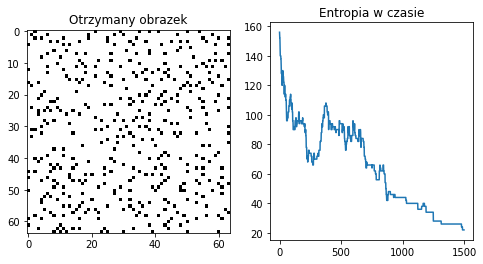

In [78]:
model.model = model.linear_model

sol, score = model.fit(
    initial_temp = 3,
    alpha = 0.002,
    max_stagnation = 500,
    epsilon = 1e-5,
    break_point=0
)
show_solution(model, sol)

- 4-sąsiedztwo, koszt jest naliczany za białe piksele w otoczeniu czarnych
- obrazek 64x64 gęstość 0.1
- liczba zamian w sąsiedztwie rozwiązań 15

In [170]:
model = ImageAnneal(
    64, 0.1,
    [get_4_nhbd],
    [1],
    15
)

Current temperature: 1.0019110898849626e-05 	 Current solution: 1122 	 Best solution: 1122 		Temperature dropped below epsilon

Number of epochs: 5365


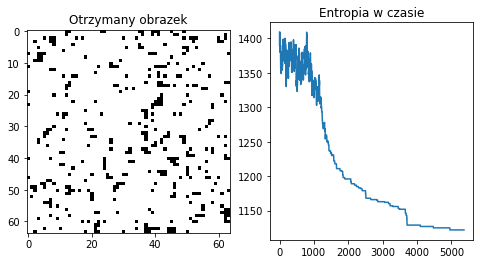

In [171]:
sol, score = model.fit(
    initial_temp = 100,
    alpha = 0.997,
    max_stagnation = 500,
    epsilon = 1e-5,
    break_point=0
)
show_solution(model, sol)

- 4-sąsiedztwo, koszt jest naliczany za czarne piksele w otoczeniu czarnych
- obrazek 64x64 gęstość 0.4
- liczba zamian w sąsiedztwie rozwiązań 20

In [164]:
model = ImageAnneal(
    64, 0.4,
    [get_4_nhbd],
    [-1],
    20
)

- Początkowa temperatura 100
- Funkcja temperatury wykładnicza o współczynniku $\alpha=0.997$
- Maksymalna liczba epok bez poprawy 500

Current temperature: 4.100151796641738e-05 	 Current solution: 1656 	 Best solution: 1656 		Number of epochs without improvement reached max_stagnation

Number of epochs: 4896


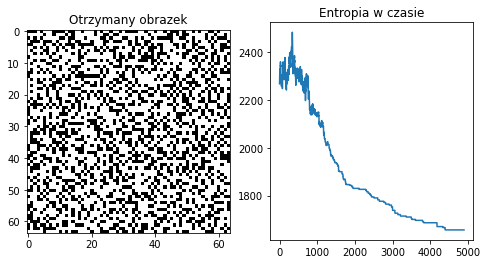

In [165]:
sol, score = model.fit(
    initial_temp = 100,
    alpha = 0.997,
    max_stagnation = 500,
    epsilon = 1e-5,
    break_point=0
)
show_solution(model, sol)

- Początkowa temperatura 5
- Funkcja temperatury liniowa o współczynniku $\alpha=0.0005$
- Maksymalna liczba epok bez poprawy 500

Current temperature: 4.231500000000426 	 Current solution: 2168 	 Best solution: 2094 		Number of epochs without improvement reached max_stagnation

Number of epochs: 1538


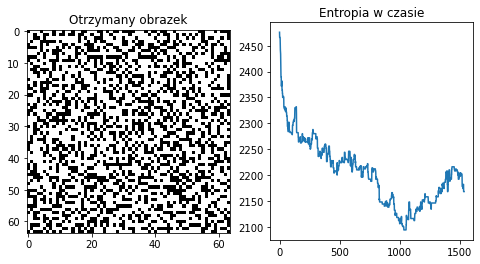

In [96]:
model.model = model.linear_model

sol, score = model.fit(
    initial_temp = 5,
    alpha = 0.0005,
    max_stagnation = 500,
    epsilon = 1e-5,
    break_point=0
)
show_solution(model, sol)

- 8-sąsiedztwo, koszt jest naliczany za czarne piksele w otoczeniu czarnych
- obrazek 64x64 gęstość 0.3
- liczba zamian w sąsiedztwie rozwiązań 10

In [131]:
model = ImageAnneal(
    64, 0.3,
    [get_8_nhbd],
    [-1],
    10
)

- Początkowa temperatura 100
- Funkcja temperatury wykładnicza o współczynniku $\alpha=0.997$
- Maksymalna liczba epok bez poprawy 500

Current temperature: 1.0019110898849626e-05 	 Current solution: 1840 	 Best solution: 1840 		Temperature dropped below epsilon

Number of epochs: 5365


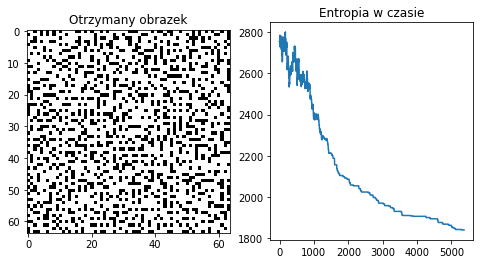

In [130]:
sol, score = model.fit(
    initial_temp = 100,
    alpha = 0.997,
    max_stagnation = 500,
    epsilon = 1e-5,
    break_point=0
)
show_solution(model, sol)

- Początkowa temperatura 5
- Funkcja temperatury liniowa o współczynniku $\alpha=0.0005$
- Maksymalna liczba epok bez poprawy 500

Current temperature: 4.535500000000257 	 Current solution: 2538 	 Best solution: 2488 		Number of epochs without improvement reached max_stagnation

Number of epochs: 930


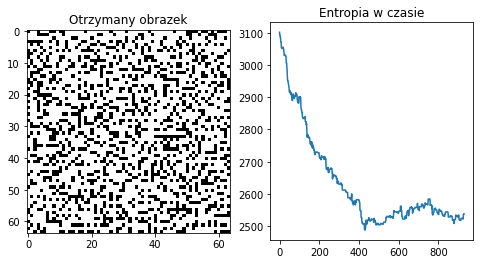

In [132]:
model.model = model.linear_model

sol, score = model.fit(
    initial_temp = 5,
    alpha = 0.0005,
    max_stagnation = 500,
    epsilon = 1e-5,
    break_point=0
)
show_solution(model, sol)

- 8-sąsiedztwo, koszt jest naliczany za czarne piksele w otoczeniu białych
- obrazek 64x64 gęstość 0.3
- liczba zamian w sąsiedztwie rozwiązań 10

In [87]:
model = ImageAnneal(
    64, 0.3,
    [get_8_nhbd],
    [1],
    10
)

- Początkowa temperatura 300
- Funkcja temperatury wykładnicza o współczynniku $\alpha=0.997$
- Maksymalna liczba epok bez poprawy 500

Current temperature: 1.000871632966156e-05 	 Current solution: 5152 	 Best solution: 5152 		Temperature dropped below epsilon

Number of epochs: 5731


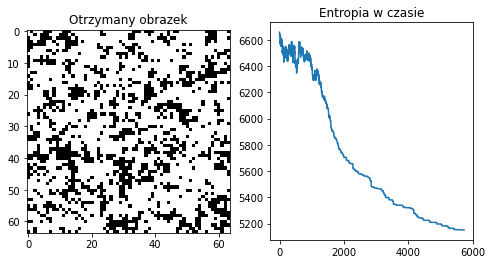

In [88]:
sol, score = model.fit(
    initial_temp = 300,
    alpha = 0.997,
    max_stagnation = 500,
    epsilon = 1e-5,
    break_point=0
)
show_solution(model, sol)

Current temperature: 3.0570000000002393 	 Current solution: 5620 	 Best solution: 5615 		Number of epochs without improvement reached max_stagnation

Number of epochs: 3887


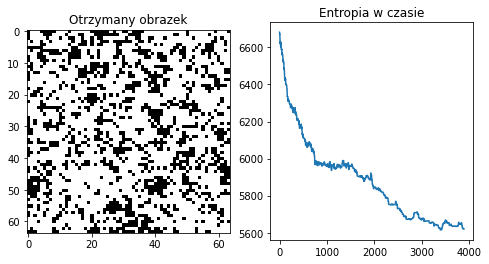

In [89]:
model.model = model.linear_model

sol, score = model.fit(
    initial_temp = 5,
    alpha = 0.0005,
    max_stagnation = 500,
    epsilon = 1e-5,
    break_point=0
)
show_solution(model, sol)

- 16-sąsiedztwo, koszt jest naliczany za czarne piksele w otoczeniu czarnych
- obrazek 64x64 gęstość 0.1
- liczba zamian w sąsiedztwie rozwiązań 10

In [33]:
model = ImageAnneal(
    64, 0.4,
    [get_16_nhbd],
    [-1],
    10
)

- Początkowa temperatura 100
- Funkcja temperatury wykładnicza o współczynniku $\alpha=0.997$
- Maksymalna liczba epok bez poprawy 500

Current temperature: 1.0019110898849626e-05 	 Current solution: 8096 	 Best solution: 8096 		Temperature dropped below epsilon

Number of epochs: 5365


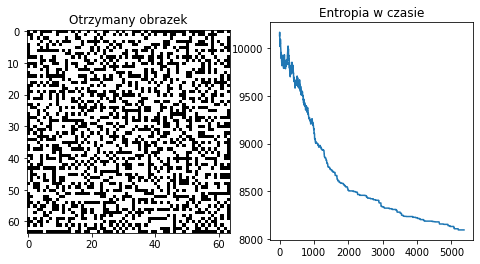

In [34]:
sol, score = model.fit(
    initial_temp = 100,
    alpha = 0.997,
    max_stagnation = 500,
    epsilon = 1e-5,
    break_point=0
)
show_solution(model, sol)

- Początkowa temperatura 15
- Funkcja temperatury liniowa o współczynniku $\alpha=0.005$
- Maksymalna liczba epok bez poprawy 500

Current temperature: 0.004999999999054935 	 Current solution: 8434 	 Best solution: 8434 		Temperature dropped below epsilon

Number of epochs: 3000


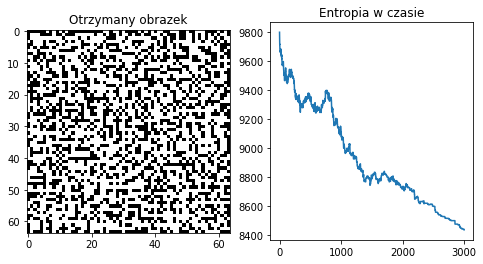

In [31]:
model.model = model.linear_model

sol, score = model.fit(
    initial_temp = 15,
    alpha = 0.005,
    max_stagnation = 500,
    epsilon = 1e-5,
    break_point=0
)
show_solution(model, sol)

- 16-sąsiedztwo, koszt jest naliczany za białe piksele w otoczeniu czarnych
- obrazek 64x64 gęstość 0.1
- liczba zamian w sąsiedztwie rozwiązań 30

In [178]:
model = ImageAnneal(
    64, 0.4,
    [get_16_nhbd],
    [1],
    30
)

- Początkowa temperatura 300
- Funkcja temperatury wykładnicza o współczynniku $\alpha=0.9972$
- Maksymalna liczba epok bez poprawy 500

Current temperature: 1.0005942931603246e-05 	 Current solution: 13236 	 Best solution: 13236 		Temperature dropped below epsilon

Number of epochs: 6141


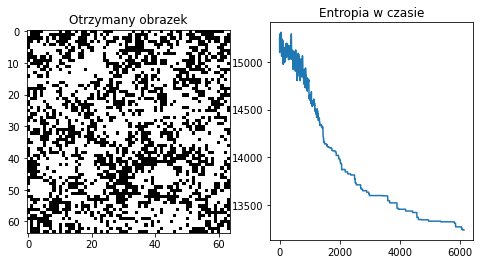

In [179]:
sol, score = model.fit(
    initial_temp = 300,
    alpha = 0.9972,
    max_stagnation = 500,
    epsilon = 1e-5,
    break_point=0
)
show_solution(model, sol)

## Próby konstrukcji labiryntu

- obrazek 64x64 gęstość 0.4
- liczba zamian w sąsiedztwie rozwiązań 100
- Złożenie 3 funkcji kosztu
    - 8-sąsiedztwo z wagą -1
    - sąsiedztwio w postaci obwodu kwadrtatu o długości boku 5 z wagą 3
    - różnica 8-sąsiedztwa oraz 4-sąsiedztwa z wagą -5

In [108]:
model = ImageAnneal(
    64, 0.4,
    [get_8_nhbd, yield_square_nhbd(2), nhbd_diff(get_8_nhbd, get_4_nhbd)],
    [-1, 3, -5],
    100
)

- Początkowa temperatura 500
- Funkcja temperatury wykładnicza o współczynniku $\alpha=0.9965$
- Maksymalna liczba epok bez poprawy 500

In [182]:
sol, score = model.fit(
    initial_temp = 500,
    alpha = 0.9965,
    max_stagnation = 300,
    epsilon = 1e-5,
    break_point=0
)

Current temperature: 0.0030567195973533476 	 Current solution: 13670 	 Best solution: 13670 		Number of epochs without improvement reached max_stagnation

Number of epochs: 3425


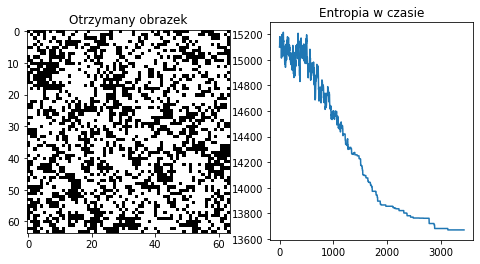

In [183]:
show_solution(model, sol)

- obrazek 64x64 gęstość 0.3
- liczba zamian w sąsiedztwie rozwiązań 100
- Złożenie 3 funkcji kosztu
    - 8-sąsiedztwo z wagą -1
    - sąsiedztwio w postaci obwodu kwadrtatu o długości boku 5 z wagą 3
    - różnica 8-sąsiedztwa oraz 4-sąsiedztwa z wagą -2

In [111]:
model = ImageAnneal(
    64, 0.3,
    [get_8_nhbd, yield_square_nhbd(2), nhbd_diff(get_8_nhbd, get_4_nhbd)],
    [-1, 3, -2],
    100
)

- Początkowa temperatura 100
- Funkcja temperatury wykładnicza o współczynniku $\alpha=0.997$
- Maksymalna liczba epok bez poprawy 500

In [114]:
sol, score = model.fit(
    initial_temp = 100,
    alpha = 0.997,
    max_stagnation = 300,
    epsilon = 1e-5,
    break_point=0
)

Current temperature: 11.845745594733453 	 Current solution: 43058 	 Best solution: 43048 		Number of epochs without improvement reached max_stagnation

Number of epochs: 711


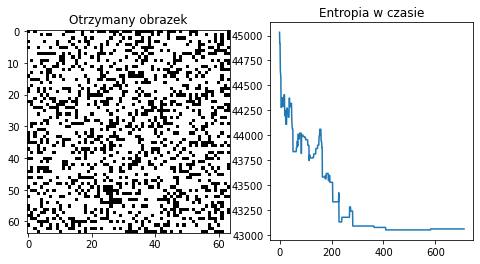

In [115]:
show_solution(model, sol)

- obrazek 64x64 gęstość 0.4
- liczba zamian w sąsiedztwie rozwiązań 100
- Złożenie 3 funkcji kosztu
    - 8-sąsiedztwo z wagą -1
    - sąsiedztwio w postaci obwodu kwadrtatu o długości boku 5 z wagą 3
    - różnica 8-sąsiedztwa oraz 4-sąsiedztwa z wagą -2

In [116]:
model = ImageAnneal(
    64, 0.4,
    [get_8_nhbd, yield_square_nhbd(2), nhbd_diff(get_8_nhbd, get_4_nhbd)],
    [-1, 3, -2],
    100
)

- Początkowa temperatura 150
- Funkcja temperatury wykładnicza o współczynniku $\alpha=0.997$
- Maksymalna liczba epok bez poprawy 500

In [120]:
sol, score = model.fit(
    initial_temp = 150,
    alpha = 0.997,
    max_stagnation = 300,
    epsilon = 1e-5,
    break_point=0
)

Current temperature: 6.875807142931889 	 Current solution: 52454 	 Best solution: 52444 		Number of epochs without improvement reached max_stagnation

Number of epochs: 1027


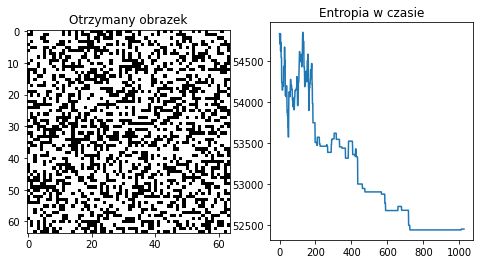

In [121]:
show_solution(model, sol)

- obrazek 64x64 gęstość 0.4
- liczba zamian w sąsiedztwie rozwiązań 100
- Złożenie 3 funkcji kosztu
    - 4-sąsiedztwo z wagą -4
    - sąsiedztwio w postaci obwodu kwadrtatu o długości boku 5 z wagą 3
    - różnica 8-sąsiedztwa oraz 4-sąsiedztwa z wagą -1

In [138]:
model = ImageAnneal(
    64, 0.4,
    [get_4_nhbd, yield_square_nhbd(2), nhbd_diff(get_8_nhbd, get_4_nhbd)],
    [-4, 3, -1],
    100
)

- Początkowa temperatura 150
- Funkcja temperatury wykładnicza o współczynniku $\alpha=0.9975$
- Maksymalna liczba epok bez poprawy 500

In [185]:
sol, score = model.fit(
    initial_temp = 150,
    alpha = 0.9975,
    max_stagnation = 300,
    epsilon = 1e-5,
    break_point=0
)

Current temperature: 0.007621904032449901 	 Current solution: 13706 	 Best solution: 13706 		Number of epochs without improvement reached max_stagnation

Number of epochs: 3951


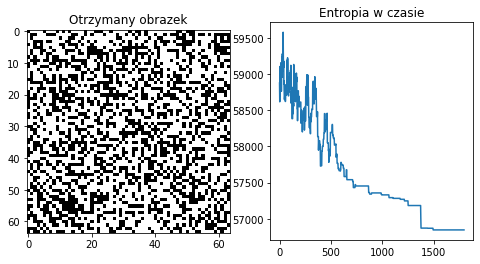

In [142]:
show_solution(model, sol)

- Początkowa temperatura 75
- Funkcja temperatury liniowa o współczynniku $\alpha=0.015$
- Maksymalna liczba epok bez poprawy 500

Current temperature: 59.834999999999425 	 Current solution: 56515 	 Best solution: 56217 		Number of epochs without improvement reached max_stagnation

Number of epochs: 1012


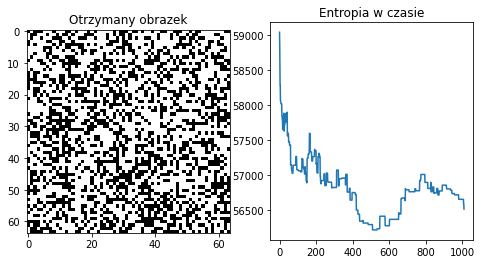

In [153]:
model.model = model.linear_model

sol, score = model.fit(
    initial_temp = 75,
    alpha = 0.015,
    max_stagnation = 500,
    epsilon = 1e-5,
    break_point=0
)
show_solution(model, sol)

- obrazek 64x64 gęstość 0.4
- liczba zamian w sąsiedztwie rozwiązań 60
- Złożenie 3 funkcji kosztu
    - 8-sąsiedztwo z wagą -2
    - 16-sąsiedztwo z wagą 3
    - różnica 8-sąsiedztwa oraz 4-sąsiedztwa z wagą -1

In [194]:
model = ImageAnneal(
    64, 0.4,
    [get_8_nhbd, get_16_nhbd, nhbd_diff(get_8_nhbd, get_4_nhbd)],
    [-2, 3, -1],
    60
)

- Początkowa temperatura 150
- Funkcja temperatury wykładnicza o współczynniku $\alpha=0.9973$
- Maksymalna liczba epok bez poprawy 300

In [195]:
sol, score = model.fit(
    initial_temp = 100,
    alpha = 0.9973,
    max_stagnation = 300,
    epsilon = 1e-5,
    break_point=0
)

Current temperature: 0.01678835772380332 	 Current solution: 56178 	 Best solution: 56178 		Number of epochs without improvement reached max_stagnation

Number of epochs: 3216


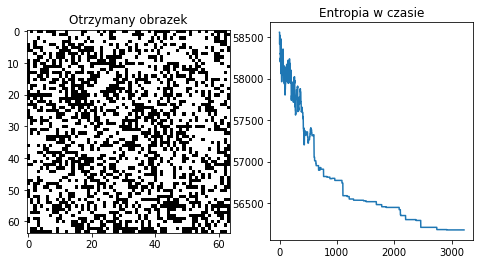

In [196]:
show_solution(model, sol)

- obrazek 64x64 gęstość 0.4
- liczba zamian w sąsiedztwie rozwiązań 60
- Złożenie 3 funkcji kosztu
    - sąsiedztwo w postaci obwodu kwadratu o boku 5 z wagą 2
    - 8-sąsiedztwo z wagą -1
    - 16-sąsiedztwo z wagą -2

In [28]:
model = ImageAnneal(
    64, 0.4,
    [yield_square_nhbd(2), get_8_nhbd, get_16_nhbd],
    [2, -1, -2],
    10
)

- Początkowa temperatura 150
- Funkcja temperatury wykładnicza o współczynniku $\alpha=0.9973$
- Maksymalna liczba epok bez poprawy 300

In [29]:
sol, score = model.fit(
    initial_temp = 100,
    alpha = 0.9973,
    max_stagnation = 300,
    epsilon = 1e-5,
    break_point=0
)

Current temperature: 1.0016299433837065e-05 	 Current solution: 48222 	 Best solution: 48222 		Temperature dropped below epsilon

Number of epochs: 5962


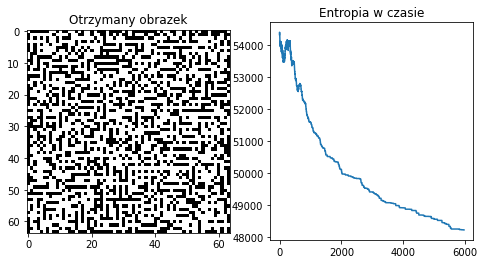

In [30]:
show_solution(model, sol)

- obrazek 64x64 gęstość 0.4
- liczba zamian w sąsiedztwie rozwiązań 60
- Złożenie 3 funkcji kosztu
    - sąsiedztwo w postaci obwodu kwadratu o boku 5 z wagą 4
    - 8-sąsiedztwo z wagą -1
    - 16-sąsiedztwo z wagą -2

In [32]:
model = ImageAnneal(
    64, 0.4,
    [yield_square_nhbd(2), get_8_nhbd, get_16_nhbd],
    [4, -1, -2],
    10
)

Current temperature: 0.010000000000382052 	 Current solution: 77986 	 Best solution: 77986 		Temperature dropped below epsilon

Number of epochs: 4500


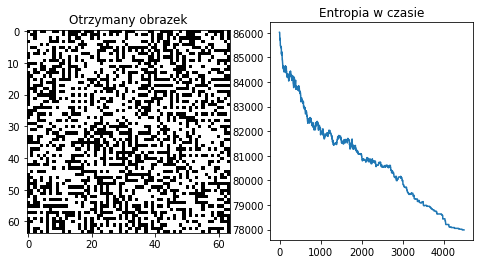

In [34]:
model.model = model.linear_model

sol, score = model.fit(
    initial_temp = 45,
    alpha = 0.01,
    max_stagnation = 500,
    epsilon = 1e-5,
    break_point=0
)
show_solution(model, sol)